In [1]:
import re
import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from keras.models import Model
from keras.models import load_model
from keras.layers import Input, Dense, GRU, concatenate
from keras import metrics
from keras import backend as K
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# Custom library for the project
import sys
sys.path.insert(0, '../../../src')
import harmoutil
from custom_callbacks import MultiAccuracyBestPerformanceCheckpoint
%matplotlib inline

/home/maxime/.local/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# # Remove when done with kernel
import importlib
importlib.reload(harmoutil)

<module 'harmoutil' from '../../../src/harmoutil.py'>

In [3]:
### Load raw data ###
raw_data = harmoutil.load_pickled_data("../../../data/refined_data.pkl") # lists of (chord label, melody seqs) by sections

### Augment data ###
augmented_data = harmoutil.transpose_and_augment_data(raw_data)

data = [harmoutil.to_triads(section) for section in augmented_data]
data = [harmoutil.melody_to_octave_range(section) for section in data]

chords = [ch for section in data for ch, mel in section]
roots, suffixes = harmoutil.roots_and_suffixes(chords) # added for model 2
melodies_by_beats = [mel for section in data for ch, mel in section]

melodies_by_notes = []
for mel in melodies_by_beats:
    melodies_by_notes.append([n for b in mel for n in b])
notes = [n for sec in melodies_by_notes for n in sec]
print(len(chords), len(melodies_by_beats), len(melodies_by_notes), len(notes))

334344 334344 334344 2209944


In [4]:
### Define class integer mappings ###

# Melody notes labels
notes_index = dict(
    [(c, i) for i, c in enumerate(sorted(list(set(notes)))[1:])])
notes_index[-1] = len(notes_index)
notes_index['<end>'] = len(notes_index)
notes_index['<pad>'] = len(notes_index)

index_notes = dict(
    [(v, k) for k, v in notes_index.items()])


# Chord labels
chords_index = dict(
    [(c, i) for i, c in enumerate(sorted(list(set(chords))))])
chords_index['<bos>'] = len(chords_index)
chords_index['<eos>'] = len(chords_index)

index_chords = dict(
    [(v, k) for k, v in chords_index.items()])


# Root labels
roots_index = dict(
    [(c, i) for i, c in enumerate(sorted(list(set(roots))))])
roots_index['<bos>'] = len(roots_index)
roots_index['<eos>'] = len(roots_index)

index_roots = dict(
    [(v, k) for k, v in roots_index.items()])


# Suffix labels
suffixes_index = dict(
    [(c, i) for i, c in enumerate(sorted(list(set(suffixes))))])
suffixes_index['<bos>'] = len(suffixes_index)
suffixes_index['<eos>'] = len(suffixes_index)

index_suffixes = dict(
    [(v, k) for k, v in suffixes_index.items()])

print(notes_index)
print(index_notes)
print(roots_index)
print(index_roots)
print(suffixes_index)
print(index_suffixes)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, '<end>': 13, '<pad>': 14, -1: 12}
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: -1, 13: '<end>', 14: '<pad>'}
{'Db': 6, 'C': 4, 'B': 2, 'D': 5, 'A': 0, '<bos>': 13, 'E': 7, 'NC': 12, 'Gb': 11, 'Eb': 8, 'G': 10, 'Bb': 3, 'Ab': 1, '<eos>': 14, 'F': 9}
{0: 'A', 1: 'Ab', 2: 'B', 3: 'Bb', 4: 'C', 5: 'D', 6: 'Db', 7: 'E', 8: 'Eb', 9: 'F', 10: 'G', 11: 'Gb', 12: 'NC', 13: '<bos>', 14: '<eos>'}
{'': 0, 'sus': 4, '<bos>': 5, '+': 1, '-': 2, 'o': 3, '<eos>': 6}
{0: '', 1: '+', 2: '-', 3: 'o', 4: 'sus', 5: '<bos>', 6: '<eos>'}


In [5]:
### Numerical variables ###
n_chords = len(chords_index)
n_notes = len(notes_index)
n_roots = len(roots_index)
n_suffixes = len(suffixes_index)
n_chord_notes = 12
max_melody_seq_len = max([len(mel) for mel in melodies_by_notes])
max_chords_seq_len = max([len(section) for section in data])
ch_context_window = 7


print("Total number of distinct chord labels:", n_chords)
print("Total number of distinct root labels", n_roots)
print("Total number of distinct suffix labels:", n_suffixes)
print("Total number of distinct melody notes:", n_notes)
print("Number notes in chord:", n_chord_notes)
print("Maximum length of melody sequences:", max_melody_seq_len)
print("Maximum length of chord sequences:", max_chords_seq_len)
print("Number of chords taken into account for next prediction:", ch_context_window)

Total number of distinct chord labels: 63
Total number of distinct root labels 15
Total number of distinct suffix labels: 7
Total number of distinct melody notes: 15
Number notes in chord: 12
Maximum length of melody sequences: 135
Maximum length of chord sequences: 58
Number of chords taken into account for next prediction: 7


In [6]:
### Build tensors ###

# Build data lists
input_melody_eos = []
input_chords_eos = []
input_roots_eos = []
input_suffixes_eos = []
target_chords_eos = []
target_roots_eos = []
target_suffixes_eos = []

for section in data:
    chord_sequence = [ch for ch, mel in section]
    root_sequence = [harmoutil.split_root_suffix(ch)[0] for ch, mel in section]
    suffix_sequence = [harmoutil.split_root_suffix(ch)[1] for ch, mel in section]
    
    padded_root_sequence = ['<bos>']*ch_context_window + root_sequence + ['<eos>']
    padded_suffix_sequence = ['<bos>']*ch_context_window + suffix_sequence + ['<eos>']
    padded_chord_sequence = ['<bos>']*ch_context_window + chord_sequence + ['<eos>']
    for i in range(len(chord_sequence)+1):
        input_chords_eos.append(padded_chord_sequence[i:i+ch_context_window])
        target_chords_eos.append(padded_chord_sequence[i+ch_context_window])

        input_roots_eos.append(padded_root_sequence[i:i+ch_context_window])
        target_roots_eos.append(padded_root_sequence[i+ch_context_window])
        
        input_suffixes_eos.append(padded_suffix_sequence[i:i+ch_context_window])
        target_suffixes_eos.append(padded_suffix_sequence[i+ch_context_window])
        
        
    chord_mel = [mel for ch, mel in section]
    melody_sequence = []
    for mel in chord_mel:
        ch_mel = []
        for b in mel:
            for n in b:
                ch_mel.append(n)
        melody_sequence.append(ch_mel)
    melody_sequence += [['<end>']]
    input_melody_eos+= melody_sequence
    
print(len(target_chords_eos), len(input_chords_eos), len(target_roots_eos), len(input_roots_eos), len(target_suffixes_eos), len(input_suffixes_eos), len(input_melody_eos))
target_chords = [target_chords_eos[i] for i in range(len(target_chords_eos)) if not target_chords_eos[i] == '<eos>']
input_chords = [input_chords_eos[i] for i in range(len(input_chords_eos)) if not target_chords_eos[i] == '<eos>']
target_roots = [target_roots_eos[i] for i in range(len(target_roots_eos)) if not target_chords_eos[i] == '<eos>']
input_roots = [input_roots_eos[i] for i in range(len(input_roots_eos)) if not target_chords_eos[i] == '<eos>']
target_suffixes = [target_suffixes_eos[i] for i in range(len(target_suffixes_eos)) if not target_chords_eos[i] == '<eos>']
input_suffixes = [input_suffixes_eos[i] for i in range(len(input_suffixes_eos)) if not target_chords_eos[i] == '<eos>']

input_melody = [input_melody_eos[i] for i in range(len(input_melody_eos)) if not target_chords_eos[i] == '<eos>']    
print(len(target_chords), len(input_chords), len(target_roots), len(input_roots), len(target_suffixes), len(input_suffixes), len(input_melody))


# Build tensors

n_entries = len(target_chords)

X_melody = np.zeros((n_entries, max_melody_seq_len, n_notes), dtype='float32')

X_chords = np.zeros((n_entries, ch_context_window, n_chords), dtype='float32')
X_roots = np.zeros((n_entries, ch_context_window, n_roots), dtype='float32')
X_suffixes = np.zeros((n_entries, ch_context_window, n_chord_notes), dtype='float32')

Y_chords = np.zeros((n_entries, n_chords), dtype='float32')
Y_roots = np.zeros((n_entries, n_roots), dtype='float32')
Y_suffixes = np.zeros((n_entries, n_chord_notes), dtype='float32')

for i, (in_mel, in_ch, tg_ch, in_rt, tg_rt, in_sf, tg_sf) in enumerate(zip(input_melody, input_chords, target_chords, input_roots, target_roots, input_suffixes, target_suffixes)):
    # target chords, roots and suffixes
    Y_chords[i, chords_index[tg_ch]] = 1
    Y_roots[i, roots_index[tg_rt]] = 1
    
    if tg_sf == '<bos>':
        tg_suffix_notes = [0]*12
    else:
        tg_suffix_notes = harmoutil.root_position(tg_sf)
        
    for j, pres in enumerate(tg_suffix_notes):
        Y_suffixes[i, j] = pres
    
    # input chords, roots and suffixes
    for j, (ch, rt, sf) in enumerate(zip(in_ch, in_rt, in_sf)):
        X_chords[i, j, chords_index[ch]] = 1
        X_roots[i, j, roots_index[rt]] = 1
        
        if sf == '<bos>':
            in_suffix_notes = [0]*12
        else:
            in_suffix_notes = harmoutil.root_position(sf)

        for k, pres in enumerate(in_suffix_notes):
            X_suffixes[i, j, k] = pres
    
    # input melody
    padded_melody = in_mel + ['<pad>']*(max_melody_seq_len - len(in_mel))
    for k, note in enumerate(padded_melody):
        X_melody[i, k, notes_index[note]] = 1
        
print(int(np.sum(X_melody)), n_entries*max_melody_seq_len)
print(int(np.sum(X_chords)), n_entries*ch_context_window)
print(int(np.sum(X_roots)), n_entries*ch_context_window)
print(int(np.sum(X_suffixes)), n_entries*ch_context_window)

print(int(np.sum(Y_chords)), n_entries)
print(int(np.sum(Y_roots)), n_entries)
print(int(np.sum(Y_suffixes)), n_entries)

363228 363228 363228 363228 363228 363228 363228
334344 334344 334344 334344 334344 334344 334344
45115280 45136440
2340408 2340408
2340408 2340408
4630860 2340408
334344 334344
334344 334344
1003032 334344


In [7]:
### Train/Validation/Test sets ###
seed = 1

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)

for train_index, aux_index in strat_split.split(X_chords, Y_chords):
    X_melody_train = X_melody[train_index]
    X_chords_train = X_chords[train_index]
    X_roots_train = X_roots[train_index]
    X_suffixes_train = X_suffixes[train_index]
    Y_chords_train = Y_chords[train_index]
    Y_roots_train = Y_roots[train_index]
    Y_suffixes_train = Y_suffixes[train_index]
    
    
    X_melody_aux = X_melody[aux_index]
    X_chords_aux = X_chords[aux_index]
    X_roots_aux = X_roots[aux_index]
    X_suffixes_aux = X_suffixes[aux_index]
    Y_chords_aux = Y_chords[aux_index]
    Y_roots_aux = Y_roots[aux_index]
    Y_suffixes_aux = Y_suffixes[aux_index]
    
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=seed)
for valid_index, test_index in strat_split.split(X_chords_aux, Y_chords_aux):
    X_melody_valid = X_melody_aux[valid_index]
    X_chords_valid = X_chords_aux[valid_index]
    X_roots_valid = X_roots_aux[valid_index]
    X_suffixes_valid = X_suffixes_aux[valid_index]
    Y_chords_valid = Y_chords_aux[valid_index]
    Y_roots_valid = Y_roots_aux[valid_index]
    Y_suffixes_valid = Y_suffixes_aux[valid_index]
    
    
    X_melody_test = X_melody_aux[test_index]
    X_chords_test = X_chords_aux[test_index]
    X_roots_test = X_roots_aux[test_index]
    X_suffixes_test = X_suffixes_aux[test_index]
    Y_chords_test = Y_chords_aux[test_index]
    Y_roots_test = Y_roots_aux[test_index]
    Y_suffixes_test = Y_suffixes_aux[test_index]

print(X_melody_train.shape, X_chords_train.shape, Y_chords_train.shape, X_roots_train.shape, Y_roots_train.shape, X_suffixes_train.shape, Y_suffixes_train.shape)
print(X_melody_valid.shape, X_chords_valid.shape, Y_chords_valid.shape, X_roots_valid.shape, Y_roots_valid.shape, X_suffixes_valid.shape, Y_suffixes_valid.shape)
print(X_melody_test.shape, X_chords_test.shape, Y_chords_test.shape, X_roots_test.shape, Y_roots_test.shape, X_suffixes_test.shape, Y_suffixes_test.shape)

# train_size = melody_train.shape[0]
# test_size = melody_test.shape[0]

(267475, 135, 15) (267475, 7, 63) (267475, 63) (267475, 7, 15) (267475, 15) (267475, 7, 12) (267475, 12)
(33434, 135, 15) (33434, 7, 63) (33434, 63) (33434, 7, 15) (33434, 15) (33434, 7, 12) (33434, 12)
(33435, 135, 15) (33435, 7, 63) (33435, 63) (33435, 7, 15) (33435, 15) (33435, 7, 12) (33435, 12)


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 135, 15)       0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 7, 15)         0                                            
____________________________________________________________________________________________________
input_3 (InputLayer)             (None, 7, 12)         0                                            
____________________________________________________________________________________________________
gru_1 (GRU)                      (None, 128)           55296       input_1[0][0]                    
___________________________________________________________________________________________

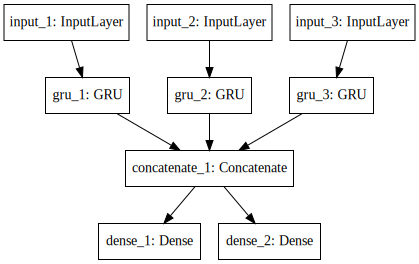

In [8]:
### Define neural net architectur ###
latent_dim = 128

melody_input = Input(shape=(max_melody_seq_len, n_notes))
melody_gru = GRU(latent_dim)(melody_input)

roots_input = Input(shape=(ch_context_window, n_roots))
roots_gru = GRU(latent_dim)(roots_input)

suffixes_input = Input(shape=(ch_context_window, n_chord_notes))
suffixes_gru = GRU(latent_dim)(suffixes_input)

concat = concatenate([melody_gru, roots_gru, suffixes_gru])

root_dense = Dense(n_roots, activation='softmax')(concat)
suffix_dense = Dense(n_chord_notes, activation='sigmoid')(concat)

model = Model([melody_input, roots_input, suffixes_input], [root_dense, suffix_dense])
model.compile(loss=['categorical_crossentropy', 'binary_crossentropy'],
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [9]:
### Introduce Early-Stopping and Save Best Performance callbacks ###
# es = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min')
# filepath = "../../models/model-2_cc-5.h5"
# bp = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

filepath = "../../models/model-3_cc-7.h5"
mabpc = MultiAccuracyBestPerformanceCheckpoint(filepath, monitor=['val_dense_1_acc', 'val_dense_2_acc'], verbose=1)


In [10]:
batch_size = 32
epochs = 50
history = model.fit([X_melody_train, X_roots_train, X_suffixes_train], [Y_roots_train, Y_suffixes_train], epochs=epochs, validation_data=([X_melody_valid, X_roots_valid, X_suffixes_valid], [Y_roots_valid, Y_suffixes_valid]), batch_size=batch_size, callbacks=[mabpc])#, callbacks=[es, bp])

Train on 267475 samples, validate on 33434 samples
Epoch 1/50
267456/267475 [============================>.] - ETA: 0s - loss: 1.8412 - dense_1_loss: 1.7164 - dense_2_loss: 0.1248 - dense_1_acc: 0.4791 - dense_2_acc: 0.9458
Epoch 00001: ['val_dense_1_acc', 'val_dense_2_acc'] improved from [0.0, 0.0] => -inf to [0.4941975235040517, 0.9476853905521655] => 1.44188, saving model to ../../models/model-3_cc-5.h5
267475/267475 [==============================] - 1114s - loss: 1.8412 - dense_1_loss: 1.7164 - dense_2_loss: 0.1248 - dense_1_acc: 0.4791 - dense_2_acc: 0.9458 - val_loss: 1.7648 - val_dense_1_loss: 1.6469 - val_dense_2_loss: 0.1179 - val_dense_1_acc: 0.4942 - val_dense_2_acc: 0.9477
Epoch 2/50
267456/267475 [============================>.] - ETA: 0s - loss: 1.7041 - dense_1_loss: 1.5872 - dense_2_loss: 0.1169 - dense_1_acc: 0.5062 - dense_2_acc: 0.9477
Epoch 00002: ['val_dense_1_acc', 'val_dense_2_acc'] improved from [0.4941975235040517, 0.9476853905521655] => 1.44188 to [0.51665968

267475/267475 [==============================] - 1113s - loss: 1.2220 - dense_1_loss: 1.1213 - dense_2_loss: 0.1007 - dense_1_acc: 0.6330 - dense_2_acc: 0.9566 - val_loss: 1.3378 - val_dense_1_loss: 1.2354 - val_dense_2_loss: 0.1024 - val_dense_1_acc: 0.6084 - val_dense_2_acc: 0.9561
Epoch 27/50
267456/267475 [============================>.] - ETA: 0s - loss: 1.2282 - dense_1_loss: 1.1276 - dense_2_loss: 0.1006 - dense_1_acc: 0.6308 - dense_2_acc: 0.9567
Epoch 00027: ['val_dense_1_acc', 'val_dense_2_acc'] did not improve from 1.58556
267475/267475 [==============================] - 1112s - loss: 1.2282 - dense_1_loss: 1.1276 - dense_2_loss: 0.1006 - dense_1_acc: 0.6308 - dense_2_acc: 0.9567 - val_loss: 1.3249 - val_dense_1_loss: 1.2234 - val_dense_2_loss: 0.1014 - val_dense_1_acc: 0.6134 - val_dense_2_acc: 0.9562
Epoch 28/50
267456/267475 [============================>.] - ETA: 0s - loss: 1.2408 - dense_1_loss: 1.1401 - dense_2_loss: 0.1007 - dense_1_acc: 0.6249 - dense_2_acc: 0.9566
E

KeyboardInterrupt: 

NameError: name 'history' is not defined

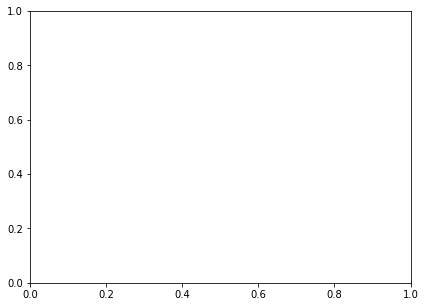

In [12]:
### Visualize model learning ###
plt.clf()

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['dense_1_acc'])
plt.plot(history.history['val_dense_1_acc'])
plt.plot(history.history['dense_2_acc'])
plt.plot(history.history['val_dense_2_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['root_train', 'root_validation', 'suffix_train', 'suffix_validation'], loc='upper left')
# plt.show()

plt.subplot(1, 2, 2)
plt.plot(history.history['dense_1_loss'])
plt.plot(history.history['val_dense_1_loss'])
plt.plot(history.history['dense_2_loss'])
plt.plot(history.history['val_dense_2_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['root_train', 'root_validation', 'suffix_train', 'suffix_validation'], loc='upper left')
plt.tight_layout()
plt.suptitle("Training history of root+suffix model", fontsize=16)
plt.subplots_adjust(top=0.85)
plt.show()

In [10]:
### Load best performance model ###
model = load_model("../../models/model-3_cc-7.h5")

In [11]:
### Evaluate predictions ###
[root_pred, suffix_pred] = model.predict([X_melody_test, X_roots_test, X_suffixes_test])

# Build tensor of combined predictions
# chord_pred = np.zeros((len(test_index), n_chords), dtype='float32')
# for i, (root_softmax, suffix_softmax) in enumerate(zip(root_pred, suffix_pred)):
#     root_index = np.argmax(root_softmax)
#     suffix_index = np.argmax(suffix_softmax)
#     root_str = index_roots[root_index]
#     suffix_str = index_suffixes[suffix_index]
#     label = root_str + suffix_str if not root_str == 'NC' else 'NC' 
#     chord_pred[i, chords_index[label]] = 1
    

# Compute accuracy and kappa score 
print("Categorical accuracy of root prediction: {0:.4f}".format(harmoutil.compute_accuracy_score(Y_roots_test, root_pred)))
print("Categorical accuracy of suffix prediction: {0:.4f}".format(harmoutil.compute_multiclass_binary_accuracy_score(Y_suffixes_test, suffix_pred)))
# print("Categorical accuracy of combined chord prediction: {0:.4f}".format(harmoutil.compute_accuracy_score(Y_chords_test, chord_pred)))

print("Kappa score of root prediction: {0:.4f}".format(harmoutil.compute_kappa_score(Y_roots_test, root_pred)))
print("Kappa score of suffix prediction: {0:.4f}".format(harmoutil.compute_multiclass_binary_kappa_score(Y_suffixes_test, suffix_pred)))
# print("Kappa score of combined chord prediction: {0:.4f}".format(harmoutil.compute_kappa_score(Y_chords_test, chord_pred)))



Categorical accuracy of root prediction: 0.6346
Categorical accuracy of suffix prediction: 0.9562
Kappa score of root prediction: 0.6015
TP: 91457 TN: 292189 FP: 8726 FN: 8848
301037 300915
100183 100305
Kappa score of suffix prediction: 0.8831


In [12]:
### Evaluate performnce in terms of note presence ###

# Convertroot+suffix prediction to note presence vector (as in Model 4)
converted_preds_list = []
for rt, sf in zip(root_pred, suffix_pred):
    root_label = index_roots[np.argmax(rt)]
    if not root_label == 'NC':    
#         note_positions = harmoutil.root_position(suffix_label)
        note_positions = [round(i) for i in sf]
        shift = harmoutil.root_index(root_label)
        note_presence = harmoutil.shift(note_positions, shift)
        if len(note_presence)>12:
            print(suffix_label, note_positions, root_label, shift, note_presence) 
    else:
        note_presence = [0]*12
        
    converted_preds_list.append(note_presence)
    
    
# Convert original groundtruth test set chords to note presence vector (as in Model 4)
converted_trues_list = []
for row in Y_chords_test:
    prediction = index_chords[np.argmax(row)]
    note_presence = harmoutil.chord_to_notes(prediction)
    converted_trues_list.append(note_presence)
    
# Create tesnsors of converted data
converted_preds = np.zeros((Y_chords_test.shape[0], 12), dtype='float32')
converted_trues = np.zeros((Y_chords_test.shape[0], 12), dtype='float32')
for i, (pred, true) in enumerate(zip(converted_preds_list, converted_trues_list)):
#     print(pred)
    for j, pred_pres in enumerate(pred):
#         print(j, pred_pres)
        converted_preds[i, j] = pred_pres
    for k, true_pres in enumerate(true):
        converted_trues[i, k] = true_pres
        
# Compute accuracy
print("Accuracy: {0:.4f}".format(harmoutil.compute_multiclass_binary_accuracy_score(converted_trues, converted_preds)))
print("Kappa: {0:.4f}".format(harmoutil.compute_multiclass_binary_kappa_score(converted_trues, converted_preds)))
print("F-score: {0:.4f}".format(harmoutil.compute_binary_fscore(converted_trues, converted_preds)))

Accuracy: 0.8318
TP: 66305 TN: 267439 FP: 33629 FN: 33847
301286 301068
99934 100152
Kappa: 0.5507
F-score: 0.6628
